# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
# pd.set_option("display.max_rows", None, "display.max_columns", None)

In [3]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

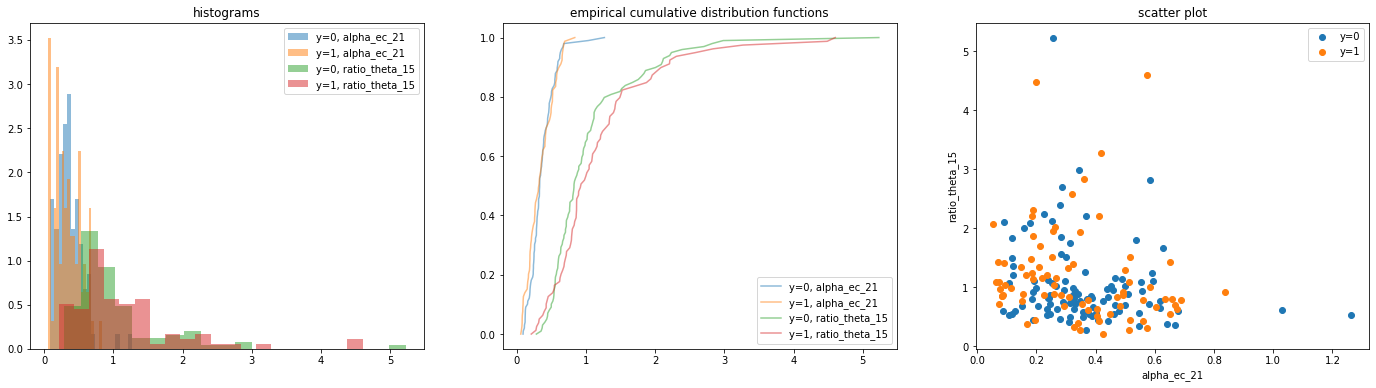

In [4]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

<b>Step 1:</b><br>
Data Analysis and exploration

In [5]:
#Extract data as dataframe to explore later on
features = pd.DataFrame(data=X, columns=feature_names)
features

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_38,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47
0,0.111840,0.123870,0.128580,0.113240,0.105710,0.106900,0.107560,0.110640,0.108750,0.158930,...,0.57161,0.73870,0.58709,0.55198,0.54811,0.57869,0.59345,0.60436,0.56294,1.01440
1,0.298340,0.268810,0.262390,0.380090,0.343580,0.285000,0.247910,0.250330,0.260470,0.260160,...,0.35142,0.32788,0.43164,0.49603,0.40680,0.31283,0.66352,0.58386,0.46658,0.74867
2,0.369120,0.395870,0.389990,0.257720,0.405540,0.441990,0.440040,0.399470,0.315460,0.283480,...,0.61924,0.86506,1.09310,0.31759,0.36353,0.50553,0.33478,0.49383,0.62363,0.61417
3,0.761200,0.777260,0.770420,0.601610,0.701830,0.727250,0.762450,0.789040,0.729840,0.522360,...,0.23456,0.25090,0.43196,0.71301,0.53340,0.28528,0.68135,0.66315,0.25250,0.85448
4,0.167700,0.151460,0.147140,0.157280,0.149650,0.141540,0.132280,0.127600,0.143510,0.172520,...,1.82160,1.73190,1.24420,2.76220,3.00930,2.43520,2.53070,2.58470,2.00770,2.29460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.079822,0.081258,0.079273,0.083723,0.069784,0.063498,0.061792,0.059784,0.066457,0.077352,...,1.31050,1.16220,0.95190,2.32520,1.87490,1.74620,2.72400,2.71860,2.82880,1.23630
176,0.346500,0.362790,0.343660,0.277240,0.316030,0.379750,0.420140,0.452390,0.421380,0.250020,...,0.69648,0.67680,0.82459,0.37865,0.45749,0.61751,0.35155,0.48109,0.65537,0.64262
177,0.159210,0.157820,0.169680,0.178980,0.140980,0.132490,0.126600,0.130490,0.149720,0.222240,...,1.04600,0.85727,0.64390,0.87481,1.09470,0.99918,0.65529,0.63907,0.62307,1.07070
178,0.941110,0.952930,0.950500,0.726600,0.766260,0.655290,0.636660,0.645460,0.763470,0.841900,...,1.14790,0.94833,0.59572,0.80736,0.71848,0.96166,0.98636,0.99212,0.97502,0.97734


<b>CHOOSE METHOD 1 OR 2 !</b>

<b>METHOD 1</b>

In [6]:
#Alpha, beta and theta waves for eyes open
alpha_eo = X[:,0:48]
beta_eo = X[:,48:48*2]
theta_eo = X[:,48*2:48*3]
#Alpha, beta and theta waves for eyes closed
alpha_ec = X[:,48*3:48*4]
beta_ec = X[:,48*4:48*5]
theta_ec = X[:,48*5:48*6]
#Ratio for alpha beta and theta eyes open/ eyes closed
alpha_r = X[:,48*6:48*7]
beta_r = X[:,48*7:48*8]
theta_r = X[:,48*8:48*9]
#Add all features in a list for ease of manipulation
independent_variables = [alpha_eo,alpha_ec,alpha_r,beta_eo,beta_ec,beta_r,theta_eo,theta_ec,theta_r]

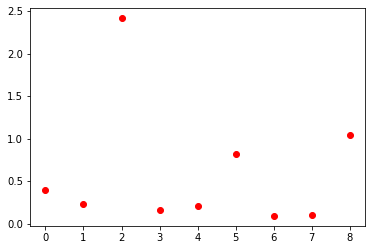

In [7]:
#Get the means of each feature and plot them
means = []
for feature in independent_variables:
    means.append(np.mean(feature))
plt.scatter(range(0,len(independent_variables)),means,c="r")

In [8]:
#Calculate correlation matrix to check the values of between 0 and 1 of all features, it would be a good idea
#to eliminate features that are highly correlated
corr_matrix = features.corr(method = "spearman").abs()
corr_matrix

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_38,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47
alpha_ec_0,1.000000,0.989266,0.974127,0.928035,0.954385,0.905561,0.905018,0.914154,0.925492,0.890386,...,0.313388,0.276932,0.228001,0.353406,0.421567,0.357065,0.328734,0.330885,0.379433,0.235195
alpha_ec_1,0.989266,1.000000,0.988893,0.888488,0.941879,0.915331,0.924755,0.935213,0.942670,0.895723,...,0.303879,0.270733,0.238767,0.376716,0.419192,0.348961,0.354491,0.342821,0.371056,0.250961
alpha_ec_2,0.974127,0.988893,1.000000,0.889283,0.924277,0.896954,0.912421,0.932984,0.956147,0.932329,...,0.297007,0.261037,0.230100,0.366896,0.402103,0.334140,0.344579,0.328929,0.356959,0.269605
alpha_ec_3,0.928035,0.888488,0.889283,1.000000,0.902318,0.803035,0.785376,0.803412,0.842477,0.875698,...,0.307334,0.282632,0.207268,0.276048,0.391187,0.344313,0.237680,0.278584,0.375744,0.224523
alpha_ec_4,0.954385,0.941879,0.924277,0.902318,1.000000,0.968590,0.948881,0.937364,0.923475,0.854847,...,0.404719,0.367832,0.288997,0.413375,0.459977,0.435250,0.372153,0.359557,0.438648,0.279181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ratio_theta_43,0.357065,0.348961,0.334140,0.344313,0.435250,0.417336,0.401833,0.395094,0.383211,0.315018,...,0.911803,0.856181,0.656876,0.745673,0.860072,1.000000,0.670286,0.743155,0.908735,0.598169
ratio_theta_44,0.328734,0.354491,0.344579,0.237680,0.372153,0.419999,0.422256,0.405745,0.363110,0.302921,...,0.577209,0.585228,0.634801,0.884264,0.678949,0.670286,1.000000,0.888793,0.745596,0.486970
ratio_theta_45,0.330885,0.342821,0.328929,0.278584,0.359557,0.375690,0.376718,0.369026,0.335001,0.316208,...,0.615316,0.640708,0.702976,0.767692,0.711881,0.743155,0.888793,1.000000,0.870389,0.440131
ratio_theta_46,0.379433,0.371056,0.356959,0.375744,0.438648,0.417938,0.404808,0.400229,0.384347,0.341697,...,0.785156,0.802687,0.719439,0.716239,0.806198,0.908735,0.745596,0.870389,1.000000,0.496422


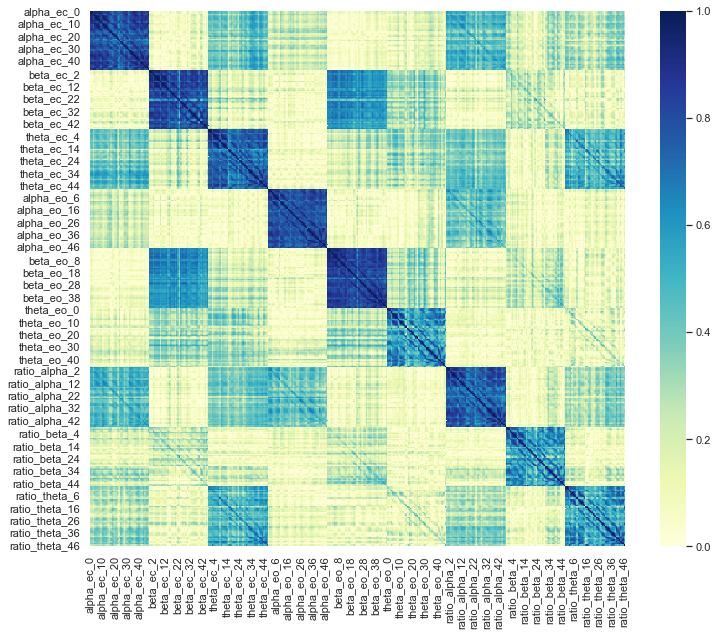

In [9]:
# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
# plt.savefig("correlation_matrix.png", dpi = 1080)

In [10]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
reduced_features = features.drop(to_drop, axis = 1)
reduced_features.shape

(180, 350)

In [11]:
from sklearn.feature_selection import VarianceThreshold
#Remove quasi-constant features with no variance => no information to give
qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(reduced_features)
(reduced_features.columns[qconstant_filter.get_support()])

Index(['alpha_ec_0', 'alpha_ec_3', 'alpha_ec_9', 'alpha_ec_16', 'alpha_ec_17',
       'alpha_ec_18', 'alpha_ec_19', 'alpha_ec_20', 'alpha_ec_21',
       'alpha_ec_22',
       ...
       'ratio_theta_38', 'ratio_theta_39', 'ratio_theta_40', 'ratio_theta_41',
       'ratio_theta_42', 'ratio_theta_43', 'ratio_theta_44', 'ratio_theta_45',
       'ratio_theta_46', 'ratio_theta_47'],
      dtype='object', length=228)

In [12]:
#By the result above, we see that there are 14 quasi constant feature ! which will allow us to further reduce the dims
reduced_features = qconstant_filter.transform(reduced_features)
#New reduced dimensions of features:
reduced_features.shape

(180, 228)

In [13]:
reduced_features_df = pd.DataFrame(data=reduced_features)

In [14]:
reduced_features_T = reduced_features.T
reduced_features_T = pd.DataFrame(data=reduced_features_T)

In [15]:
print(reduced_features_T.duplicated().sum())

0


In [19]:
X = reduced_features

In [20]:
#No duplicates were found. Good !
#Now after cleaning and reducing further and further, we can check with any bagging algorithm the importance of our features
# and if we kept the correct ones !
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X, y)

DecisionTreeClassifier(random_state=42)

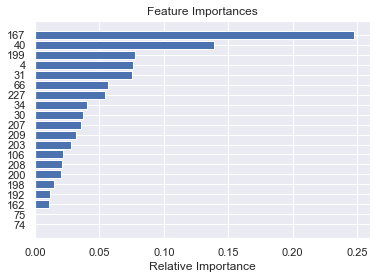

228


In [21]:
#Determine feature importance using the tree regressor
features_cols = reduced_features_df.columns
importances = dtc.feature_importances_
indices = np.argsort(importances)[-20:]  # top 20 features (others are not as effective as they can be)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
print(len(importances))
#After narrowing down from 432 features, we clearly see that a lot of features have little to no effect on the
#model performance, hence the plot below determines well which features should be kept and which should be dropped

In [76]:
from sklearn.feature_selection import SelectKBest, f_classif
anova = SelectKBest(score_func=f_classif, k = 'all')
anova.fit(X,y)
X_anova = anova.transform(X)
X_anova.shape

(180, 228)

In [89]:
groups = np.zeros(180).astype(int)

counter = 0
subject = 0

while(counter < 180):
    if(counter%10==0 and counter !=0):
        subject+=1
    groups[counter] = subject
    counter+=1

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut,LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# model = LogisticRegression()
model = SVC(kernel="linear")
LOOCV = LeaveOneGroupOut()
cv = LOOCV.split(X_anova, y, groups)
n_scores = cross_val_score(model, X_anova, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.839 (0.111)


<b>DIFFERENT METHODS ! #######################################</b>

<b> METHOD 2</b>

In [31]:
#Check which features are mostly correlated with Y labels
data = features
data["labels"] = y
data_corr = data.corr(method = "spearman").abs()
x_y_corr = data_corr["labels"].sort_values(ascending = False)
mean_corr = np.mean(x_y_corr)
final_corr = x_y_corr[x_y_corr > mean_corr]
final_corr

labels            1.000000
ratio_beta_34     0.482194
ratio_beta_5      0.449703
ratio_beta_37     0.439590
ratio_beta_35     0.439375
                    ...   
beta_ec_21        0.146100
theta_ec_10       0.145885
ratio_alpha_6     0.145669
ratio_alpha_21    0.145669
beta_eo_30        0.145455
Name: labels, Length: 189, dtype: float64

In [32]:
#Retrieve from features the ones who are the most correlated with y (corr > mean_value)
data_2_keep = []
for idx, val in final_corr.items():
    data_2_keep.append(idx)
del data_2_keep[0]
data_2_keep
features_reduced_1 = features[data_2_keep]
opt_corr_mat = features_reduced_1.corr(method = "spearman").abs()
opt_corr_mat

,ratio_beta_34,ratio_beta_5,ratio_beta_37,ratio_beta_35,ratio_beta_4,ratio_beta_0,ratio_beta_1,ratio_beta_29,ratio_beta_2,ratio_beta_7,...,beta_eo_1,theta_ec_2,theta_eo_19,alpha_eo_11,theta_ec_30,beta_ec_21,theta_ec_10,ratio_alpha_6,ratio_alpha_21,beta_eo_30
ratio_beta_34,1.000000,0.646606,0.738889,0.878090,0.651757,0.712960,0.714359,0.644570,0.770163,0.721942,...,0.276039,0.263365,0.054819,0.060208,0.362124,0.230785,0.364581,0.325817,0.320000,0.282961
ratio_beta_5,0.646606,1.000000,0.655991,0.654488,0.884589,0.780273,0.809879,0.575993,0.727688,0.892644,...,0.326924,0.078439,0.002652,0.316010,0.029214,0.200490,0.026250,0.012708,0.107293,0.264125
ratio_beta_37,0.738889,0.655991,1.000000,0.826166,0.706528,0.748142,0.706133,0.798864,0.719417,0.621548,...,0.274500,0.139941,0.057442,0.120872,0.210907,0.146574,0.255142,0.200237,0.198971,0.375575
ratio_beta_35,0.878090,0.654488,0.826166,1.000000,0.668063,0.786429,0.768519,0.721274,0.815216,0.701273,...,0.299303,0.130549,0.025743,0.085962,0.174338,0.194037,0.207263,0.181373,0.192910,0.323437
ratio_beta_4,0.651757,0.884589,0.706528,0.668063,1.000000,0.798893,0.746782,0.641768,0.689412,0.783293,...,0.164026,0.024080,0.010974,0.225147,0.108693,0.334613,0.085595,0.115462,0.024365,0.174392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
beta_ec_21,0.230785,0.200490,0.146574,0.194037,0.334613,0.321092,0.257022,0.261749,0.240521,0.212898,...,0.627538,0.148530,0.246092,0.009844,0.077758,1.000000,0.022920,0.003510,0.068525,0.597594
theta_ec_10,0.364581,0.026250,0.255142,0.207263,0.085595,0.155486,0.140124,0.186841,0.220407,0.055621,...,0.097260,0.802408,0.248390,0.095324,0.810110,0.022920,1.000000,0.463076,0.531362,0.132326
ratio_alpha_6,0.325817,0.012708,0.200237,0.181373,0.115462,0.030670,0.046514,0.023543,0.136358,0.056375,...,0.017854,0.381181,0.053835,0.472698,0.438713,0.003510,0.463076,1.000000,0.778071,0.067303
ratio_alpha_21,0.320000,0.107293,0.198971,0.192910,0.024365,0.023482,0.028810,0.083362,0.139618,0.011631,...,0.088616,0.475945,0.066278,0.416733,0.463782,0.068525,0.531362,0.778071,1.000000,0.191312


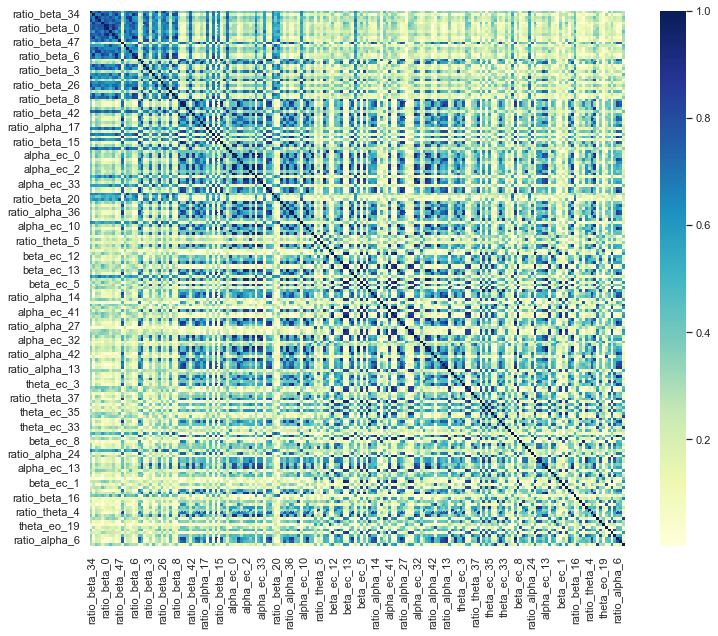

In [33]:
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(opt_corr_mat, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()

In [34]:
#Remove high variance!
upper = opt_corr_mat.where(np.triu(np.ones(opt_corr_mat.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
features_reduced_2 = features_reduced_1.drop(to_drop, axis = 1)
features_reduced_2.shape

(180, 152)

In [35]:
from sklearn.feature_selection import VarianceThreshold
#Remove quasi-constant features with no variance => no information to give
qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(features_reduced_2)
labels = (features_reduced_2.columns[qconstant_filter.get_support()])
for i in labels:
    print(i)

ratio_beta_34
ratio_beta_5
ratio_beta_37
ratio_beta_35
ratio_beta_4
ratio_beta_0
ratio_beta_1
ratio_beta_29
ratio_beta_2
ratio_beta_7
ratio_beta_47
ratio_alpha_3
ratio_beta_21
ratio_beta_38
ratio_beta_36
ratio_beta_13
ratio_alpha_9
alpha_ec_25
ratio_beta_10
ratio_beta_3
alpha_ec_23
ratio_beta_30
ratio_beta_33
alpha_ec_17
ratio_beta_26
ratio_beta_41
ratio_beta_12
alpha_ec_31
ratio_beta_11
ratio_beta_8
alpha_ec_34
ratio_alpha_34
ratio_alpha_33
alpha_ec_30
ratio_beta_42
alpha_ec_35
ratio_alpha_26
ratio_alpha_47
alpha_ec_26
ratio_alpha_17
ratio_beta_9
ratio_alpha_25
ratio_beta_14
ratio_alpha_0
ratio_beta_15
alpha_ec_16
ratio_beta_43
ratio_theta_35
alpha_ec_0
alpha_ec_47
ratio_alpha_41
ratio_alpha_23
ratio_theta_42
ratio_beta_28
alpha_ec_37
alpha_ec_33
ratio_beta_22
ratio_alpha_15
ratio_alpha_2
ratio_beta_39
ratio_beta_20
ratio_beta_17
ratio_alpha_16
ratio_alpha_36
ratio_alpha_37
alpha_ec_9
ratio_beta_25
ratio_theta_36
ratio_theta_5
alpha_ec_38
ratio_theta_34
beta_ec_12
ratio_theta_41
beta_

In [36]:
#Make sure new features are highly correlated with Y and have high variance
features_reduced_3 = qconstant_filter.transform(features_reduced_2)
colnames = [column for column in labels]
features_reduced_3 = pd.DataFrame(data=features_reduced_3,columns=colnames)
reduced_data  = features_reduced_3
# reduced_data["labels"] = y
# reduced_corr = reduced_data.corr(method="spearman").abs()
# x_y_corr = reduced_corr["labels"].sort_values(ascending = False)
# mean_corr = np.mean(x_y_corr)
# final_corr = x_y_corr[x_y_corr > mean_corr]
# final_corr
X_opt = reduced_data.values
X_opt.shape

(180, 115)

In [91]:
#Test efficiency for using the reduced dims of features
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

LOOCV = LeaveOneGroupOut()
cv = LOOCV.split(X, y, groups)
y[y == 0] = -1 #Perform for SVM output of {-1,1}
svc = SVC(kernel="linear")
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=100)
pipeline = Pipeline(steps=[('s',rfe),('m',svc)])
# pipeline = Pipeline(steps=[('m',svc)])
n_scores = cross_val_score(pipeline, X, y,
                           scoring='accuracy', cv=cv,
                           n_jobs=-1, error_score='raise') #Change X to X_opt for reduced features
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

KeyboardInterrupt: 

In [13]:
# #We will use a recrusive algorithm to eliminate non essential features next
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import LeaveOneOut
# from sklearn.feature_selection import RFE
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix

# # y[y == 0] = -1
# # rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=18)
# LOOCV = LeaveOneOut()
# svc = SVC(kernel="linear")
# # model = DecisionTreeClassifier()
# pipeline = Pipeline(steps=[('m',model)])
# n_scores = cross_val_score(pipeline, X_anova, y, scoring='accuracy', cv=LOOCV, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [54]:
#Baseline code
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, LeavePGroupsOut,LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

y[y == 0] = -1
y_true = []
y_pred = []

model = SVC(kernel = "linear")

groups = np.zeros(180).astype(int)

counter = 0
subject = 0

while(counter < 180):
    if(counter%10==0 and counter !=0):
        subject+=1
    groups[counter] = subject
    counter+=1
    
gkf = GroupKFold(n_splits=18)
gss = GroupShuffleSplit(n_splits=18, random_state=42)
lpgo = LeavePGroupsOut(n_groups=1)
logo = LeaveOneGroupOut()

X_dims = features_reduced_2

cv = logo.split(X_dims, y, groups)

scoring = ['precision_macro', 'recall_macro']

scores = cross_val_score(model, X_dims, y, scoring="accuracy", cv=cv, n_jobs=-1, error_score='raise')
# print(sorted(scores.keys()))
# print(np.mean(scores["fit_time"]))
print(np.mean(scores))
# y_pred = cross_val_predict(model, X_dims, y, cv=cv)

# cm = confusion_matrix(y, y_pred)
# TP = cm[0][0]
# FP = cm[0][1]
# FN = cm[1][0]
# TN = cm[1][1]
# sp = TN/(TN + FP)
# se = TP/(TP + FN)
# acc = (TP + TN)/(TP+FP+FN+TN)
# pr = TP/(TP+FP)
# f1 = 2*pr*se/(pr+se)

# print(f"se: {se}, sp: {sp}, acc: {acc}, pr: {pr}, f1: {f1}")
# print(cm)
# f, t, th = roc_curve(y, y_pred)
# print(f"AUC: {auc(f,t)}")

0.8833333333333334


In [206]:
#Baseline code
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, LeavePGroupsOut,LeaveOneGroupOut

y[y == 0] = -1
y_true = []
y_pred = []

model = SVC(kernel = "linear")
# model = LogisticRegression()

groups = np.zeros(180).astype(int)

counter = 0
subject = 0

while(counter < 180):
    if(counter%10==0 and counter !=0):
        subject+=1
    groups[counter] = subject
    counter+=1
    
# gkf = GroupKFold(n_splits=18)
gss = GroupShuffleSplit(n_splits=18, random_state=42)
# lpgo = LeavePGroupsOut(n_groups=1)
# logo = LeaveOneGroupOut()

scores = []

X_dims = X_opt_2

sens = []
spec = []

for train_index, test_index in gss.split(X_dims,y,groups=groups):
#      print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_dims[train_index], X_dims[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    print(y_hat.shape)
#     y_true.append(y_test)
#     y_pred.append(y_hat)
#     acc = accuracy_score(y_test, y_hat)
    cm = confusion_matrix(y_test, y_hat)
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    sp = TN/(TN + FP)
    se = TP/(TP + FN)
    sens.append(se)
    spec.append(sp)
    acc = (TP + TN)/(TP+FP+FN+TN)
    scores.append(acc)

# print(1 - np.mean(loss))
print(np.mean(scores))
print(np.mean(sens))
# print(y_pred)
# y_pred = np.array(y_pred)
# y_true = np.array(y_true)
# acc = accuracy_score(y_true, y_pred)
# print(y_pred.shape)
# acc
# print(y_pred.shape)
# print(groups)
# cm = confusion_matrix(y_true, y_pred)
# confusion_matrix(
#     y_true.argmax(axis=1), y_pred.argmax(axis=1))
# TP = cm[0][0]
# FP = cm[0][1]
# FN = cm[1][0]
# TN = cm[1][1]
# sp = TN/(TN + FP)
# se = TP/(TP + FN)
# acc = (TP + TN)/(TP+FP+FN+TN)
# pr = TP/(TP+FP)
# f1 = 2*pr*se/(pr+se)
# print(f"se: {se}, sp: {sp}, acc: {acc}, pr: {pr}, f1: {f1}")
# print(cm)
# f, t, th = roc_curve(y_true, y_pred)
# print(f"AUC: {auc(f,t)}")

(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
0.8319444444444445
0.8045702567972683


In [56]:
#LEAVE ONE SUBJECT OUT CV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

y[y == 0] = -1
y_true = []
y_pred = []

svm = SVC(kernel = "linear")
# gss = GroupShuffleSplit(=1,train_size=.7, random_state=42)
gkf = GroupKFold(n_splits=3)

groups = np.zeros(180).astype(int)
counter = 0
subject = 0
while(counter < 180):
    if(counter%10==0 and counter !=0):
        subject+=1
    groups[counter] = subject
    counter+=1

for train_index, test_index in gkf.split(X_opt,y,groups):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X_opt[train_index], X_opt[test_index]
     y_train, y_test = y[train_index], y[test_index]
     svm.fit(X_train, y_train)
     y_hat = svm.predict(X_test)
     y_pred.append(y_hat)
     y_true.append(y_test)
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
acc = accuracy_score(y_true, y_pred)
# cm = confusion_matrix(y_true, y_pred)
# TP = cm[0][0]
# FP = cm[0][1]
# FN = cm[1][0]
# TN = cm[1][1]
# sp = TN/(TN + FP)
# se = TP/(TP + FN)
# acc = (TP + TN)/(TP+FP+FN+TN)
# pr = TP/(TP+FP)
# f1 = 2*pr*se/(pr+se)
# print(f"se: {se}, sp: {sp}, acc: {acc}, pr: {pr}, f1: {f1}")
# print(cm)
# f, t, th = roc_curve(y_true, y_pred)
# print(f"AUC: {auc(f,t)}")

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169] TEST: [ 20  21  22  23  24  25  26  27  28  29  50  51  52  53  54  55  56  57
  58  59  80  81  82  83  84  85  86  87  88  89 110 111 112 113 114 115
 116 117 118 119 140 141 142 143 144 145 146 147 148 149 170 171 172 173
 174 175 176 177 178 179]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  70  71  72  73
  74  75  76  77  78  79  80

0.0

In [181]:
#Modified Data :
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

y[y == 0] = -1
y_true = []
y_pred = []

svm = SVC(kernel = "linear")

for train_index, test_index in LOOCV.split(X):
     X_train, X_test = X_opt[train_index], X_opt[test_index]
     y_train, y_test = y[train_index], y[test_index]
     svm.fit(X_train, y_train)
     y_hat = svm.predict(X_test)
     print(y_hat.shape)
     y_pred.append(y_hat)
     y_true.append(y_test)
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
print(y_pred.shape)
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
sp = TN/(TN + FP)
se = TP/(TP + FN)
acc = (TP + TN)/(TP+FP+FN+TN)
pr = TP/(TP+FP)
f1 = 2*pr*se/(pr+se)
print(f"se: {se}, sp: {sp}, acc: {acc}, pr: {pr}, f1: {f1}")
print(cm)
f, t, th = roc_curve(y_true, y_pred)
print(f"AUC: {auc(f,t)}")

(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(180, 1)
se: 0.898989898989899, sp: 0.8641975308641975, acc: 0.8833333333333333, pr: 0.89, f1: 0.894

In [17]:
#Modified Data :
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

y[y == 0] = -1
y_true = []
y_pred = []

X_opt_2 = features_reduced_2.values

svm = SVC(kernel = "linear")

for train_index, test_index in LOOCV.split(X_opt_2):
     X_train, X_test = X_opt_2[train_index], X_opt_2[test_index]
     y_train, y_test = y[train_index], y[test_index]
     svm.fit(X_train, y_train)
     y_hat = svm.predict(X_test)
     y_pred.append(y_hat)
     y_true.append(y_test)
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
sp = TN/(TN + FP)
se = TP/(TP + FN)
acc = (TP + TN)/(TP+FP+FN+TN)
pr = TP/(TP+FP)
f1 = 2*pr*se/(pr+se)
print(f"se: {se}, sp: {sp}, acc: {acc}, pr: {pr}, f1: {f1}")
print(cm)
f, t, th = roc_curve(y_true, y_pred)
print(f"AUC: {auc(f,t)}")

se: 0.9, sp: 0.875, acc: 0.8888888888888888, pr: 0.9, f1: 0.9
[[90 10]
 [10 70]]
AUC: 0.8875


In [18]:
from sklearn.feature_selection import SelectFromModel

y[y == 0] = -1
y_true = []
y_pred = []

main_model = SVC(kernel = "linear").fit(X, y)
feature = SelectFromModel(main_model)
Fit = feature.fit_transform(X, y)

print(Fit.shape)

svm_f = SVC(kernel="linear")

for train_index, test_index in LOOCV.split(Fit):
     X_train, X_test = Fit[train_index], Fit[test_index]
     y_train, y_test = y[train_index], y[test_index]
     svm_f.fit(X_train, y_train)
     y_hat = svm_f.predict(X_test)
     y_pred.append(y_hat)
     y_true.append(y_test)
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
sp = TN/(TN + FP)
se = TP/(TP + FN)
acc = (TP + TN)/(TP+FP+FN+TN)
pr = TP/(TP+FP)
f1 = 2*pr*se/(pr+se)
print(f"se: {se}, sp: {sp}, acc: {acc}, pr: {pr}, f1: {f1}")
print(cm)
f, t, th = roc_curve(y_true, y_pred)
print(f"AUC: {auc(f,t)}")

(180, 162)
se: 0.98, sp: 0.975, acc: 0.9777777777777777, pr: 0.98, f1: 0.98
[[98  2]
 [ 2 78]]
AUC: 0.9775


In [17]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

y[y == 0] = -1
y_true = []
y_pred = []

main_model = SVC(kernel = "linear").fit(X, y)
feature = SelectFromModel(main_model)
Fit = feature.fit_transform(X, y)

svm_f = LinearSVC()

for train_index, test_index in LOOCV.split(Fit):
     X_train, X_test = Fit[train_index], Fit[test_index]
     y_train, y_test = y[train_index], y[test_index]
     svm_f.fit(X_train, y_train)
     y_hat = svm_f.predict(X_test)
     y_pred.append(y_hat)
     y_true.append(y_test)
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
sp = TN/(TN + FP)
se = TP/(TP + FN)
acc = (TP + TN)/(TP+FP+FN+TN)
pr = TP/(TP+FP)
f1 = 2*pr*se/(pr+se)
print(f"se: {se}, sp: {sp}, acc: {acc}, pr: {pr}, f1: {f1}")
print(cm)

se: 0.9702970297029703, sp: 0.9746835443037974, acc: 0.9722222222222222, pr: 0.98, f1: 0.9751243781094527
[[98  2]
 [ 3 77]]


In [18]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

y[y == 0] = -1
y_true = []
y_pred = []

main_model = LassoCV()
feature = SelectFromModel(main_model)
Fit = feature.fit_transform(X, y)

svm_f = LinearSVC()

for train_index, test_index in LOOCV.split(Fit):
     X_train, X_test = Fit[train_index], Fit[test_index]
     y_train, y_test = y[train_index], y[test_index]
     svm_f.fit(X_train, y_train)
     y_hat = svm_f.predict(X_test)
     y_pred.append(y_hat)
     y_true.append(y_test)
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]
sp = TN/(TN + FP)
se = TP/(TP + FN)
acc = (TP + TN)/(TP+FP+FN+TN)
pr = TP/(TP+FP)
f1 = 2*pr*se/(pr+se)
print(f"se: {se}, sp: {sp}, acc: {acc}, pr: {pr}, f1: {f1}")
print(cm)

se: 0.8712871287128713, sp: 0.8481012658227848, acc: 0.8611111111111112, pr: 0.88, f1: 0.8756218905472637
[[88 12]
 [13 67]]
